In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm, t
from arelle import Cntlr

import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FormatStrFormatter

In [26]:
#Diccionario con el nombre de la empresa y el nombre del archivo xbrl con los estados financieros
CORPORATIVO = {"TIGO-20200930":["0052482133_0260_000050_0000_000000_000000_C-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA"],            
            "TIGO-20200630":["0052388926_0260_000050_0000_000000_000000_C-I_2020-06-30.xbrl","2020-07-01","2020-04-01","AAA"],
           "TIGO-20200331":["0052293269_0260_000050_0000_000000_000000_C-I_2020-03-31.xbrl","2020-04-01","2020-01-01","AAA"],           
           "TIGO-20191231":["0052250068_0260_000050_0000_000000_000000_C-C_2019-12-31.xbrl","2020-01-01","2019-10-01","AAA"],
              "TIGO-20190930":["0052124588_0260_000050_0000_000000_000000_C-I_2019-09-30.xbrl","2019-10-01","2019-07-01","AAA"],
              "TIGO-20190630":["0052049978_0260_000050_0000_000000_000000_C-I_2019-06-30.xbrl","2019-07-01","2019-04-01","AAA"],
              "TIGO-20190331":["0051951569_0260_000050_0000_000000_000000_C-I_2019-03-31.xbrl","2019-04-01","2019-01-01","AAA"],
              "TIGO-20181231":["0051901762_0260_000050_0000_000000_000000_C-C_2018-12-31.xbrl","2019-01-01","2018-10-01","AAA"],
              "TIGO-20180930":["0051769957_0260_000050_0000_000000_000000_C-I_2018-09-30.xbrl","2018-10-01","2018-07-01","AAA"],
              "TIGO-20180630":["0051684634_0260_000050_0000_000000_000000_C-I_2018-06-30.xbrl","2018-07-01","2018-04-01","AAA"],
              "TIGO-20180331":["0051599051_0260_000050_0000_000000_000000_C-I_2018-03-31.xbrl","2018-04-01","2018-01-01","AAA"],
              "TIGO-20171231":["0051532876_0260_000050_0000_000000_000000_C-C_2017-12-31.xbrl","2018-01-01","2017-10-01","AAA"],
              "TIGO-20170930":["0051426142_0260_000050_0000_000000_000000_C-I_2017-09-30.xbrl","2017-10-01","2017-07-01","AAA"],
              "TIGO-20170630":["0051330206_0260_000050_0000_000000_000000_C-I_2017-06-30.xbrl","2017-07-01","2017-04-01","AAA"],
              "TIGO-20170331":["0051257115_0260_000050_0000_000000_000000_C-I_2017-03-31.xbrl","2017-04-01","2017-01-01","AAA"],
              "TIGO-20161231":["0051210493_0260_000050_0000_000000_000000_C-C_2016-12-31.xbrl","2017-01-01","2016-10-01","AAA"]}

             
#Crear dataframe para almacenar datos de las empresas
datos_empresas = pd.DataFrame().T

#Iteramos para todos los elementos en el diccionario
for key in CORPORATIVO:
    
    EEFF_EMPRESA = CORPORATIVO[key][0]
    
    #Importamos archivo xbrl
    xbrl = Cntlr.Cntlr().modelManager.load(r'C:/Users/andrgome/DEUDA PRIVADA/Emisores/2021 Tigo/EEFF/'+EEFF_EMPRESA)
        
    #Lo convertimos a un dataframe
    factData=pd.DataFrame(data=[(fact.concept.qname,
                               fact.value,
                               fact.isNumeric,
                               fact.contextID,
                               fact.context.isStartEndPeriod,
                               fact.context.isInstantPeriod,
                               fact.context.isForeverPeriod,
                               fact.context.startDatetime,
                               fact.context.endDatetime,
                               fact.unitID) for fact in xbrl.facts])

    #Volvemos texto la columna cero
    factData['Nombre'] = factData.apply(lambda row: str(row[0]),axis=1)
    #Volvemos numérica la columna 1
    factData[1] = pd.to_numeric(factData[1],errors='coerce')
    #Extraemos datos financieros
    #Pasivo corriente 
    Pasivo_corriente = factData[(factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    #Pasivo no corriente 
    Pasivo_no_corriente = factData[(factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000

    #Activos Totales
    Activos_totales = factData[(factData['Nombre']=="ifrs:Assetss")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:Assets")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:Assets")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000

    #Activo Corriente
    Activo_corriente = factData[(factData['Nombre']=="ifrs:CurrentAssets")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:CurrentAssets")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:CurrentAssets")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    
    #Caja y equivalentes
    Caja_y_equivalentes = factData[(factData['Nombre']=="ifrs:CashAndCashEquivalents")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:CashAndCashEquivalents")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:CashAndCashEquivalents")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000

    
    #Caja y equivalentes
    Bonos_emitidos = factData[(factData['Nombre']=="ifrs:BondsIssued")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:BondsIssued")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:BondsIssued")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000   

    
    #Deuda
    Deudas = factData[(factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000   


    #Patrimonio
    Patrimonio = factData[(factData['Nombre']=="ifrs:Equity")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:Equity")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:Equity")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000   

    
    #Ingresos
    Ingresos = factData[(factData['Nombre']=="ifrs:Revenue")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:Revenue")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:Revenue")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000   


    #Utilidad operativa
    Utilidad_operativa = factData[(factData['Nombre']=="ifrs:ProfitLossFromOperatingActivities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:ProfitLossFromOperatingActivities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:ProfitLossFromOperatingActivities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000   

    
    #Utilidad antes de impuestos
    Utilidad_antes_de_imptos = factData[(factData['Nombre']=="ifrs:ProfitLossBeforeTax")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:ProfitLossBeforeTax")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:ProfitLossBeforeTax")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000   

    #Resultado del período
    Resultado_período = factData[(factData['Nombre']=="ifrs:ProfitLoss")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:ProfitLoss")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:ProfitLoss")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000
    
    #Gastos operacionales
    Gastos_operacionales = factData[(factData['Nombre']=="ifrs:OperatingExpenseExcludingCostOfSales")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:OperatingExpenseExcludingCostOfSales")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:OperatingExpenseExcludingCostOfSales")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    
    #Gastos Financieros   
    Gastos_financieros = factData[(factData['Nombre']=="ifrs:FinanceCosts")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:FinanceCosts")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:FinanceCosts")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000
    
    #Depreciaciones y amortizaciones    
    Depreciaciones_amortizaciones = factData[(factData['Nombre']=="ifrs:DepreciationAndAmortisationExpense")&(factData[3]=="_ctx1")&(factData[1]!=0)|
                        (factData['Nombre']=="ifrs:DepreciationAndAmortisationExpense")&(factData[3]=="CierreTrimestreActual")&(factData[1]!=0)|
                        (factData['Nombre']=="ifrs:DepreciationAndAmortisationExpense")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[1]!=0)][1].values[0]/1000    
 
    #Impuesto de renta    
    Impuestos_pagados = factData[(factData['Nombre']=="ifrs:IncomeTaxExpenseContinuingOperations")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:IncomeTaxExpenseContinuingOperations")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:IncomeTaxExpenseContinuingOperations")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))&(factData[7]==pd.to_datetime(CORPORATIVO[key][2]))][1].values[0]/1000      
                
    #Crear una lista y agregar características de las empresas
    lista_caracteristicas = []
    lista_caracteristicas.append(CORPORATIVO[key][1])
    lista_caracteristicas.append(Pasivo_corriente)
    lista_caracteristicas.append(Pasivo_no_corriente)    
    lista_caracteristicas.append(CORPORATIVO[key][2])
    lista_caracteristicas.append(Activos_totales)
    lista_caracteristicas.append(Activo_corriente)
    lista_caracteristicas.append(Caja_y_equivalentes)
    lista_caracteristicas.append(Bonos_emitidos)
    lista_caracteristicas.append(Deudas)
    lista_caracteristicas.append(Patrimonio)
    lista_caracteristicas.append(Ingresos)
    lista_caracteristicas.append(Utilidad_operativa)
    lista_caracteristicas.append(Utilidad_antes_de_imptos)
    lista_caracteristicas.append(Resultado_período)
    lista_caracteristicas.append(Gastos_operacionales)
    lista_caracteristicas.append(Gastos_financieros)
    lista_caracteristicas.append(Depreciaciones_amortizaciones)
    lista_caracteristicas.append(Impuestos_pagados)        

    datos_empresas = datos_empresas.append(pd.DataFrame(lista_caracteristicas).T)


In [27]:
datos_empresas = datos_empresas.rename(columns={0:'Fecha EEFF',
                                                1:'Pasivo Corriente',
                                                2:'Pasivo No Corriente',
                                                3:'Calificación',
                                                4:'Activos Totales',
                                                5:'Activo Corriente',
                                                6:'Caja y equivalentes',
                                                7:'Bonos emitidos',
                                                8:'Deudas',
                                                9:'Patrimonio',
                                                10:'Ingresos',
                                                11:'Utilidad operativa',
                                                12:'Utilidad antes de imptos',
                                                13:'Resultado período',
                                                14:'Gastos operacionales acumulada',
                                                15:'Gastos financieros',
                                                16:'Depreciaciones y amortizaciones acumulada',
                                                17:'Impuestos pagados',
                                               })

datos_empresas.sort_values(by='Fecha EEFF',inplace=True)

datos_empresas['Resultado período 12M'] = datos_empresas['Resultado período'].rolling(window=4).sum()
datos_empresas['ROE'] = datos_empresas['Resultado período 12M']  /datos_empresas['Patrimonio']
datos_empresas['Pasivo Corriente % del Total'] = datos_empresas['Pasivo Corriente']  /(datos_empresas['Pasivo Corriente']+datos_empresas['Pasivo No Corriente'])
datos_empresas['Pasivo % del Activo'] = (datos_empresas['Pasivo Corriente']+datos_empresas['Pasivo No Corriente'])/datos_empresas['Activos Totales'] 
datos_empresas['Activo Corriente % del Total'] = datos_empresas['Activo Corriente']  / datos_empresas['Activos Totales']
datos_empresas['Caja y equivalentes % del Total'] = datos_empresas['Caja y equivalentes']  / datos_empresas['Activos Totales']
datos_empresas['Margen Bruto'] = datos_empresas['Utilidad operativa']  / datos_empresas['Ingresos']
datos_empresas['Utilidad operativa % deuda'] = datos_empresas['Utilidad operativa']  / datos_empresas['Deudas']
datos_empresas['Gastos financieros % ingresos'] = datos_empresas['Gastos financieros']  / datos_empresas['Ingresos']

datos_empresas['Depreciaciones y amortizaciones período'] = datos_empresas['Depreciaciones y amortizaciones acumulada']
datos_empresas['Gastos operacionales período'] = datos_empresas['Gastos operacionales acumulada']

for i in range(0,datos_empresas.shape[0]):
    if i != 0:        
        if datos_empresas['Fecha EEFF'].iloc[i][-5:] != '04-01':
            datos_empresas['Depreciaciones y amortizaciones período'].iloc[i] = datos_empresas['Depreciaciones y amortizaciones acumulada'].iloc[i]-datos_empresas['Depreciaciones y amortizaciones acumulada'].iloc[i-1]
            datos_empresas['Gastos operacionales período'].iloc[i] = datos_empresas['Gastos operacionales acumulada'].iloc[i]-datos_empresas['Gastos operacionales acumulada'].iloc[i-1]
    else:
        datos_empresas['Depreciaciones y amortizaciones período'].iloc[i] = 0
        datos_empresas['Gastos operacionales período'].iloc[i] = 0

datos_empresas['Ebitda'] = datos_empresas['Resultado período']+datos_empresas['Gastos financieros']  + datos_empresas['Depreciaciones y amortizaciones período']  + datos_empresas['Impuestos pagados']
datos_empresas['Ebitda2'] = datos_empresas['Utilidad operativa']+ datos_empresas['Depreciaciones y amortizaciones período']
datos_empresas['Ebitda12M'] = datos_empresas['Ebitda'].rolling(window=4).sum()
datos_empresas['DeudaEbitda'] = datos_empresas['Deudas']/datos_empresas['Ebitda12M']



C:\Users\andrgome\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
datos_empresas

,Fecha EEFF,Pasivo Corriente,Pasivo No Corriente,Calificación,Activos Totales,Activo Corriente,Caja y equivalentes,Bonos emitidos,Deudas,Patrimonio,...,Caja y equivalentes % del Total,Margen Bruto,Utilidad operativa % deuda,Gastos financieros % ingresos,Depreciaciones y amortizaciones período,Gastos operacionales período,Ebitda,Ebitda2,Ebitda12M,DeudaEbitda
0,2017-01-01,1476682.346,3962066.308,2016-10-01,7416723.399,1422241.61,331323.248,0.0,2987351.191,1977974.745,...,0.044672,-0.050671,-0.023184,0.067638,0,0,-101774.09,-69257.507,NaN,NaN
0,2017-04-01,1283728.408,3886997.704,2017-01-01,7164328.115,1351625.844,270294.381,838960.459,3262738.139,1993602.003,...,0.037728,0.053199,0.020171,0.084532,282202.845,118506.406,403985.364,348015.453,NaN,NaN
0,2017-07-01,1333241.403,3904097.137,2017-04-01,7125254.191,1349901.431,318215.193,827374.012,2938852.012,1887915.651,...,0.04466,0.020896,0.008857,0.072991,288308.94,144710.952,267318.855,314337.182,NaN,NaN
0,2017-10-01,1435750.606,3753021.211,2017-07-01,7031150.193,1374550.967,302899.944,828057.093,2909060.193,1842378.376,...,0.04308,-0.000454,-0.000197,0.073612,299863.67,76627.948,341971.826,299290.075,911501.955,3.191502
0,2018-01-01,1446686.304,3941393.744,2017-10-01,7318716.001,1617230.531,561370.876,828740.658,2806940.658,1930635.953,...,0.076703,0.123029,0.057566,0.072977,279823.929,188047.574,434797.596,441408.131,1448073.641,1.938396
0,2018-04-01,1279795.641,3781720.792,2018-01-01,6998085.387,1429385.545,402848.092,829409.832,2656550.832,1936568.954,...,0.057565,0.039105,0.018451,0.076825,274374.112,143087.716,403624.562,323389.868,1447712.839,1.834998
0,2018-07-01,1373982.067,3836376.24,2018-04-01,7133886.708,1544934.977,541047.332,830797.351,2703037.351,1923528.401,...,0.075842,0.059306,0.028214,0.070208,272648.07,142485.192,304399.105,348911.645,1484793.089,1.820481
0,2018-10-01,1339334.87,3760005.016,2018-07-01,7023008.839,1460070.584,500074.002,831431.196,2623085.196,1923668.953,...,0.071205,0.088313,0.041921,0.075064,259480.281,116987.585,362970.112,369441.786,1505791.375,1.741998
0,2019-01-01,1459007.358,3868852.592,2018-10-01,7100129.65,1539706.118,548016.856,832065.487,2706990.487,1772269.7,...,0.077184,0.126736,0.048052,0.089053,259018.695,153132.026,287101.342,389096.226,1358095.121,1.993226
0,2019-04-01,1576449.046,4164119.482,2019-01-01,7556304.478,1500260.525,430809.787,682686.424,2685123.424,1815735.95,...,0.057013,0.107287,0.048085,0.088584,274312.369,137185.177,438017.347,403425.929,1392487.906,1.928292


C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


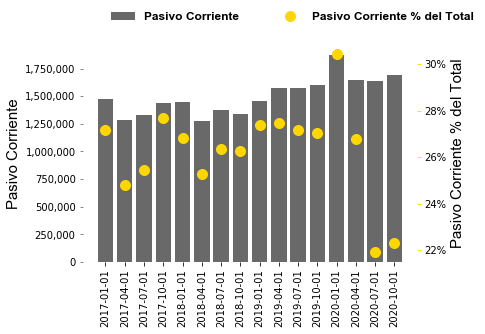

In [29]:
#Apalancamiento
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Pasivo Corriente'],color='dimgrey',label='Pasivo Corriente')
ax1.set_ylabel('Pasivo Corriente',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Pasivo Corriente % del Total'],marker='o', linestyle='None',color='gold',markersize=10,label='Pasivo Corriente % del Total')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.2, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Pasivo Corriente % del Total',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

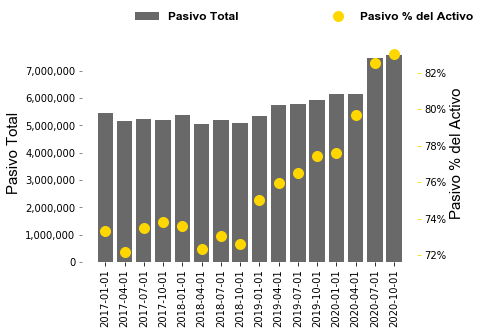

In [30]:
#Apalancamiento
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],(datos_empresas['Pasivo Corriente']+datos_empresas['Pasivo No Corriente']),color='dimgrey',label='Pasivo Total')
ax1.set_ylabel('Pasivo Total',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Pasivo % del Activo'],marker='o', linestyle='None',color='gold',markersize=10,label='Pasivo % del Activo')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.2, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Pasivo % del Activo',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

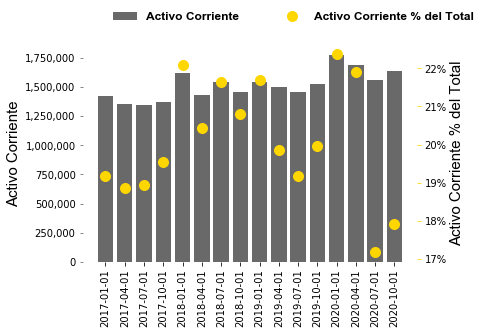

In [31]:
#Liquidez
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Activo Corriente'],color='dimgrey',label='Activo Corriente')
ax1.set_ylabel('Activo Corriente',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Activo Corriente % del Total'],marker='o', linestyle='None',color='gold',markersize=10,label='Activo Corriente % del Total')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.2, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Activo Corriente % del Total',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

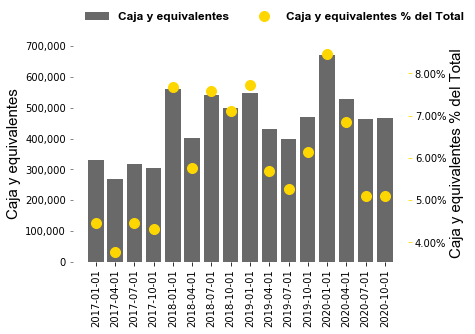

In [32]:
#Liquidez
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Caja y equivalentes'],color='dimgrey',label='Caja y equivalentes')
ax1.set_ylabel('Caja y equivalentes',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Caja y equivalentes % del Total'],marker='o', linestyle='None',color='gold',markersize=10,label='Caja y equivalentes % del Total')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.2, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Caja y equivalentes % del Total',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

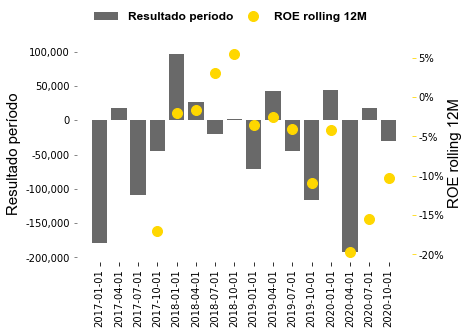

In [33]:
#Rentabilidad
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Resultado período'],color='dimgrey',label='Resultado período')
ax1.set_ylabel('Resultado período',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['ROE'],marker='o', linestyle='None',color='gold',markersize=10,label='ROE rolling 12M')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.9, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('ROE rolling 12M',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

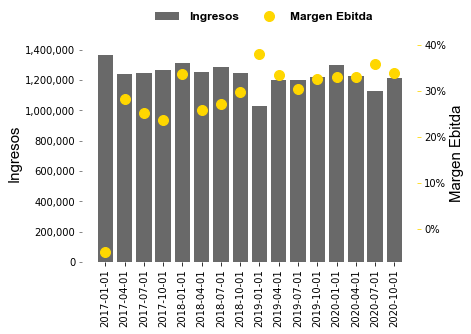

In [34]:
#Rentabilidad
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Ingresos'],color='dimgrey',label='Ingresos')
ax1.set_ylabel('Ingresos',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Ebitda2']/datos_empresas['Ingresos'],marker='o', linestyle='None',color='gold',markersize=10,label='Margen Ebitda')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.9, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Margen Ebitda',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

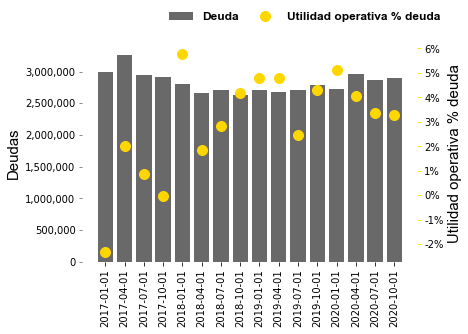

In [35]:
#Cobertura de deuda
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Deudas'],color='dimgrey',label='Deuda')
ax1.set_ylabel('Deudas',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Utilidad operativa % deuda'],marker='o', linestyle='None',color='gold',markersize=10,label='Utilidad operativa % deuda')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.1, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Utilidad operativa % deuda',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.show()

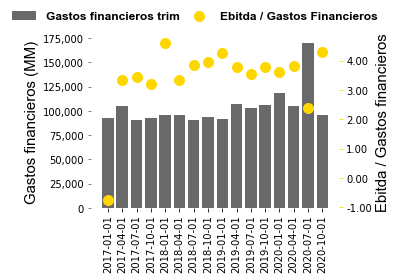

In [36]:
#Cobertura de deuda
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Gastos financieros'],color='dimgrey',label='Gastos financieros trim')
ax1.set_ylabel('Gastos financieros (MM)',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.4, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['Ebitda2']/datos_empresas['Gastos financieros'],marker='o', linestyle='None',color='gold',markersize=10,label='Ebitda / Gastos Financieros')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.2, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Ebitda / Gastos financieros',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, None, None])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)

plt.subplots_adjust(bottom=0.1, right=0.7, top=0.7)
plt.show()

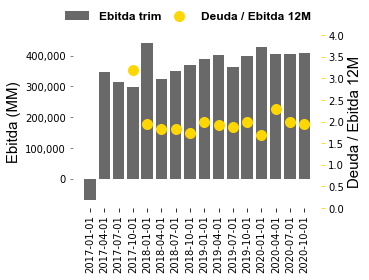

In [37]:
#Cobertura de deuda
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Ebitda2'],color='dimgrey',label='Ebitda trim')
ax1.set_ylabel('Ebitda (MM)',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.4, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

ax2 = ax1.twinx()
ax2.plot(datos_empresas['Fecha EEFF'],datos_empresas['DeudaEbitda'],marker='o', linestyle='None',color='gold',markersize=10,label='Deuda / Ebitda 12M')
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.0, 1.2),ncol=2,markerscale=1)
ax2.set_ylabel('Deuda / Ebitda 12M',fontname = "Arial", fontsize=15,color='black')
ax2.tick_params(axis='y', color = 'gold', labelcolor='black')
ax2.axis([None, None, 0, 4])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y) ))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=10)

plt.box(on=None)
plt.subplots_adjust(bottom=0.1, right=0.7, top=0.7)

plt.show()

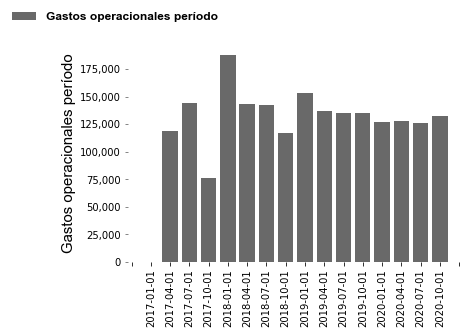

In [38]:
#Gastos operacionales
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Gastos operacionales período'],color='dimgrey',label='Gastos operacionales período')
ax1.set_ylabel('Gastos operacionales período',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.3, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.show()

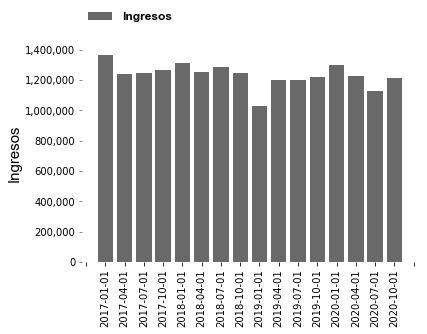

In [39]:
#Ingresos
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=12)

fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.bar(datos_empresas['Fecha EEFF'],datos_empresas['Ingresos'],color='dimgrey',label='Ingresos')
ax1.set_ylabel('Ingresos',fontname = "Arial",fontsize=15, color='black')
ax1.tick_params(axis='y', color = 'dimgrey', labelcolor='black')
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.3, 1.2),ncol=2,markerscale=3)
plt.xticks(rotation=90)
ax1.axis([None, None, None, None])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y) ))
ax1.title.set_fontfamily('arial')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.show()

In [34]:
# datos_empresas = datos_empresas.rename(columns={0:'Fecha EEFF',
#                                                 1:'Pasivo Corriente',
#                                                 2:'Pasivo No Corriente',
#                                                 3:'Calificación',
#                                                 4:'Activos Totales',
#                                                 5:'Activo Corriente',
#                                                 6:'Caja y equivalentes',
#                                                 7:'Bonos emitidos',
#                                                 8:'Deudas',
#                                                 9:'Patrimonio',
#                                                 10:'Ingresos',
#                                                 11:'Utilidad operativa',
#                                                 12:'Utilidad antes de imptos',
#                                                 13:'Resultado período',
#                                                 14:'Gastos operacionales acumulada',
#                                                 15:'Gastos financieros',
#                                                 16:'Depreciaciones y amortizaciones acumulada',
#                                                 17:'Impuestos pagados',
#                                                })


# datos_empresas['Gastos financieros']

Ratios

Most standard texts on financial statement analysis discuss ratios that characterize various aspects of a firm’s performance. While each of these ratios may provide important alternative perspectives on a firm’s condition, our experience is that including a large number of ratios in a quantitative model may yield a model that is “overfitted.” In other words, the model will perform very well on the data used to develop the model, but its performance out-of-sample on new borrowers will be poor.


To avoid an “overfitted” model, we developed and refined a process to select a limited number of financial ratios that yield a powerful model. During our selection process, we used statistical tests as well as prior modeling experience to determine which variables to include and exclude from the model.9 Our list of financial statement ratios fall under one of the following broad risk factors of financial performance: 

• Profitability

• Leverage

• Debt coverage

• Growth variables

• Liquidity

• Activity ratios

• Size 

The ratios within each of these groups are viewed as alternative readings of the same underlying construct. In building our financial statement model, we seek to include at least one variable from each group. In the doubling of data and the two years of research that led to this version, we discovered a number of insights that have improved the model. For example, size has typically been found useful as a risk factor. It is true that larger firms default less often, but when we refined our financial statement ratios and included a cash flow ratio, we found that the impact of the size advantage declined in the model. This tells us that a small firm that has very healthy financial statements is not much riskier than a larger firm with comparable financial statements in the Credit Research Database.

• Examples of ratios in the profitability group include net income, net income less extraordinary items, EBITDA, EBIT, and operating profit in the numerator; and total assets, tangible assets, fixed assets and sales in the denominator. -> High profitability reduces the probability of default.

• Examples of ratios in the leverage (or gearing) group include liabilities to assets and long-term debt to assets. These ratios measure the size of a firm's debt relative to its assets. -> High leverage increases the probability of default. 

• Growth variables are typically sales growth or asset growth. These variables measure the stability of a firm’s performance. -> Growth variables behave like a double-edged sword: both rapid growth and rapid decline (negative growth) will tend to increase a firm’s default probability. 

• Liquidity variables include cash and marketable securities to assets, the current ratio, and the quick ratio. These variables measure the extent to which the firm has liquid assets relative to the size of its liabilities. -> High liquidity reduces the probability of default. 

• Activity ratios include inventories to sales and accounts receivable turnover. These ratios measure the extent to which a firm has a substantial portion of assets in accounts that may be of subjective value. For example, a firm with a lot of inventories may not be selling its products and may have to write off these inventories. -> A large stock of inventories relative to sales increases the probability of default; other activity ratios have different relationships to default. 

• Size variables include sales and total assets. These variables are converted into a common currency as necessary and then are deflated to a specific base year to ensure comparability (e.g., total assets are measured in 2001 U.S. dollars). The size variable in the U.S. and Canadian v3.1 models is Total Assets. -> Large firms default less often.


In [4]:
# #Importamos archivo xbrl
xbrl = Cntlr.Cntlr().modelManager.load(r'C:/Users/andrgome/DEUDA PRIVADA/Emisores/2021 Tigo/EEFF/0052482133_0260_000050_0000_000000_000000_C-I_2020-09-30.xbrl')

#Lo convertimos a un dataframe
factData=pd.DataFrame(data=[(fact.concept.qname,
                           fact.value,
                           fact.isNumeric,
                           fact.contextID,
                           fact.context.isStartEndPeriod,
                           fact.context.isInstantPeriod,
                           fact.context.isForeverPeriod,
                           fact.context.startDatetime,
                           fact.context.endDatetime,
                           fact.unitID) for fact in xbrl.facts])


#Volvemos texto la columna cero
factData['Nombre'] = factData.apply(lambda row: str(row[0]),axis=1)
#Volvemos numérica la columna 1
factData[1] = pd.to_numeric(factData[1],errors='coerce')

In [6]:
# prueba = factData[factData['Nombre'].str.contains("ifrs:FinancialLiabilities")]
# prueba

# Deudas = factData[(factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[3]=="_ctx1")|
#                         (factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[3]=="CierreTrimestreActual")|
#                         (factData['Nombre']=="ifrs:FinancialLiabilities")&(factData[8]==pd.to_datetime("2020-10-01"))][1].values[0]/1000   

# Deudas
# factData.to_csv(r'C:/Users/andrgome/DEUDA PRIVADA/Emisores/2021 Tigo/EEFF/IFRS_names.csv')

2899960.635